In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import  os
import happi
import math

# 拟合
from scipy import interpolate as intp
from numpy import polyfit, poly1d

# 傅里叶变换和滤波
from scipy.fftpack import fft,ifft,fftshift,fft2
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt

from scipy.io import savemat
import h5py

pi = math.pi

plt.style.use('paper')

In [2]:
filename = '20ns'

# basic parameters
me = 1.
e = 1.
mp = 100 * me
c = 1
# -> wpe = 1

wpp = 1./np.sqrt(mp)  # proton plasma frequency
v_ratio = 15.         # c/vA
wcp = wpp/v_ratio     # cyclotron frequency
B0 = wcp*mp/e         # magnetic field magnitude

vA = c/v_ratio        # proton Afven speed
vbth = 0.03*vA        # background proton thermal velocity
vsth = 0.45*vA        # shell dist. proton thermal velocity
dt = 0.001            # simualtion time step, in wcp^-1

#使用初始背景磁场的大小来初步验证模拟结果
init_Bx = B0                     # B0 is on x axis
lambda_p = c/wpp             # characteristc length (proton inertial length)

# simulation length & grid 
Lx = 102.4*lambda_p         
Ly = 12.8*lambda_p
Nx = 512
Ny = 128
dx = Lx/Nx
dy = Ly/Ny

#setting grid
#空间上的单位是lambda_i
dx_norm = dx/lambda_p
dy_norm = dy/lambda_p
x = np.linspace(0,Nx,Nx+1)
y = np.linspace(0,Ny,Ny+1)

X,Y = np.meshgrid(x.astype(int),y.astype(int))


# integrate 
init_UB = 0.5 * init_Bx**2 * dx * dy * (Nx+1) * (Ny+2)

In [3]:
with h5py.File('./data/' + filename + '_field1.h5', 'r') as f:
    # 列出所有 dataset
    print(list(f.keys()))
    field1_t = f['field1_t'][:]
    Bx = f['Bx'][:]
    By = f['By'][:]
    Bz = f['Bz'][:]
    Ex = f['Ex'][:]
    Ey = f['Ey'][:]
    Ez = f['Ez'][:]

['Bx', 'By', 'Bz', 'Ex', 'Ey', 'Ez', 'field1_t']


In [6]:
import numpy as np
from numpy.fft import fft2, fftshift, fftfreq

def get_directional_mask(shape, dx, dy, angle_range):
    """
    生成频域方向掩码
    shape: 数据的实际形状 (Nx_act, Ny_act)
    angle_range: (min_deg, max_deg) 允许的角度区间
    """
    nx_act, ny_act = shape
    # 使用实际点数生成频率轴
    kx = fftfreq(nx_act, d=dx)
    ky = fftfreq(ny_act, d=dy)
    kx_grid, ky_grid = np.meshgrid(kx, ky, indexing='ij')
    
    # 计算角度 theta = atan(|ky| / |kx|)
    angle = np.abs(np.arctan2(np.abs(ky_grid), np.abs(kx_grid)))
    min_rad, max_rad = np.deg2rad(angle_range)
    
    mask = (angle >= min_rad) & (angle <= max_rad)
    # 返回 fftshifted 后的掩码，确保与 fftshift(fft2) 后的频谱对齐
    return fftshift(mask).astype(np.float32)

def calculate_filtered_energy(field_dict, dx, dy, mask, c_inv_sq):
    """
    使用 Parseval 定理在频域直接计算滤波后的能量演化
    """
    # 获取实际的时间步和空间点数
    sample_key = list(field_dict.keys())[0]
    Nt, Nx_act, Ny_act = field_dict[sample_key].shape
    
    total_energy = np.zeros(Nt)
    dA = dx * dy  # 空间元面积
    norm_factor = Nx_act * Ny_act  # FFT 标准化因子
    
    for t in range(Nt):
        t_energy = 0.0
        for name, data in field_dict.items():
            # 1. 2D FFT 并移到中心
            f_shifted = fftshift(fft2(data[t]))
            
            # 2. 频域过滤
            f_filtered = f_shifted * mask
            
            # 3. Parseval 定理：空间域平方和 = 频域平方和 / (Nx*Ny)
            # 能量 = sum(0.5 * field^2 * dA)
            p_sum = np.sum(np.abs(f_filtered)**2) / norm_factor
            
            # 电场分量需除以 c^2
            weight = c_inv_sq if name.startswith('E') else 1.0
            t_energy += 0.5 * p_sum * dA * weight
            
        total_energy[t] = t_energy
        
    return total_energy

# ==========================================
# 主程序逻辑
# ==========================================

# 1. 自动获取数据的实际空间形状 (处理 513, 129 等 Node 点数)
actual_spatial_shape = Bx.shape[1:] 

# 2. 准备数据字典 (Bx 建议使用扰动场：Bx - B0)
all_fields = {
    'Bx': Bx - B0, 'By': By, 'Bz': Bz,
    'Ex': Ex, 'Ey': Ey, 'Ez': Ez
}

# 3. 预计算掩码 (一次计算，到处使用)
# EMIC 波: 平行方向 (0-15度)
mask_emic = get_directional_mask(actual_spatial_shape, dx, dy, (0, 15))
# MS 波: 垂直方向 (70-90度)
mask_ms = get_directional_mask(actual_spatial_shape, dx, dy, (70, 90))

# 4. 执行高效率计算 (不再需要 IFFT)
c_inv_sq = 1.0 / (c**2)
U_EMIC_raw = calculate_filtered_energy(all_fields, dx, dy, mask_emic, c_inv_sq)
U_MS_raw = calculate_filtered_energy(all_fields, dx, dy, mask_ms, c_inv_sq)

# 5. 归一化并输出结果
U_EMIC = U_EMIC_raw / init_UB
U_MS = U_MS_raw / init_UB



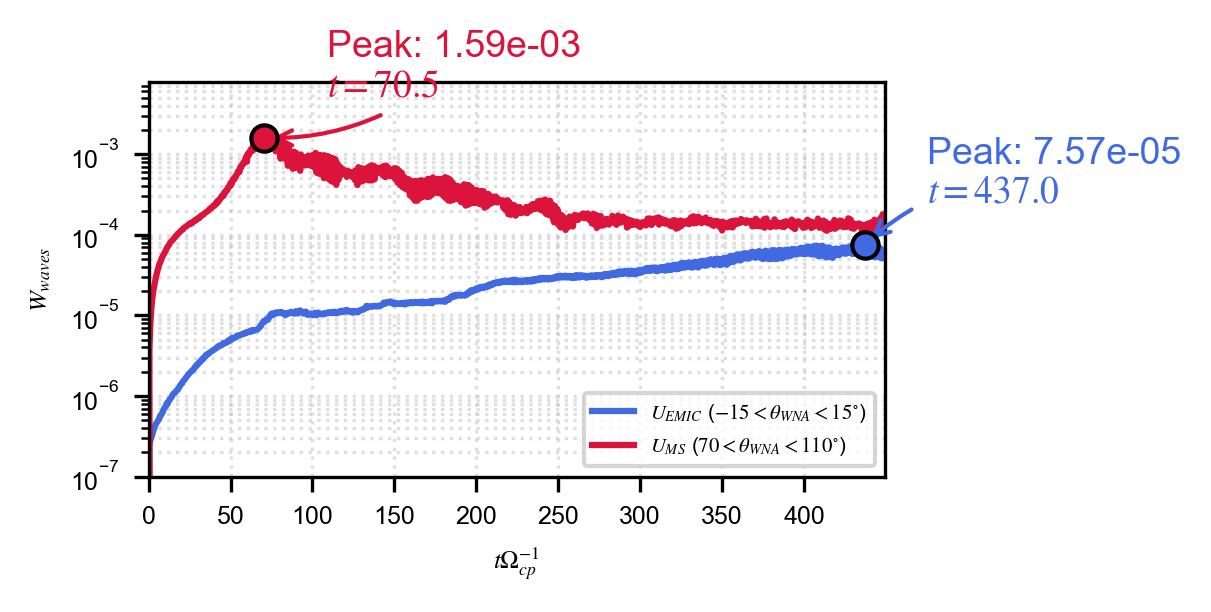

In [28]:
# 1. 准备时间轴与峰值数据
time0 = field1_t * wcp

# 计算 EMIC 峰值
idx_emic = np.argmax(U_EMIC)
max_U_EMIC = U_EMIC[idx_emic]
t_max_EMIC = time0[idx_emic]

# 计算 MS 峰值
idx_ms = np.argmax(U_MS)
max_U_MS = U_MS[idx_ms]
t_max_MS = time0[idx_ms]

# 2. 创建画布
fig, ax = plt.subplots(figsize=(4, 2))

# 3. 绘制能量演化曲线 (y轴将设为对数)
ax.plot(time0, U_EMIC, color='royalblue', lw=1.5, label=r'$U_{EMIC}$ ($-15<\theta_{WNA}<15^{\circ}$)')
ax.plot(time0, U_MS, color='crimson', lw=1.5, label=r'$U_{MS}$ ($70<\theta_{WNA}<110^{\circ}$)')

# 4. 设置 y 轴为对数坐标
ax.set_yscale('log')

# 5. 自动标注峰值 (使用科学计数法 :.2e)
# 标注 EMIC
ax.scatter(t_max_EMIC, max_U_EMIC, color='royalblue', s=40, edgecolors='black', zorder=5)
ax.annotate(f'Peak: {max_U_EMIC:.2e}\n$t={t_max_EMIC:.1f}$', 
            xy=(t_max_EMIC, max_U_EMIC), 
            xytext=(15, 10), textcoords='offset points',
            color='royalblue', fontsize=9, fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='royalblue', connectionstyle="arc3,rad=.2"))

# 标注 MS
ax.scatter(t_max_MS, max_U_MS, color='crimson', s=40, edgecolors='black', zorder=5)
ax.annotate(f'Peak: {max_U_MS:.2e}\n$t={t_max_MS:.1f}$', 
            xy=(t_max_MS, max_U_MS), 
            xytext=(15, 10), textcoords='offset points',
            color='crimson', fontsize=9, fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='crimson', connectionstyle="arc3,rad=-.2"))

# 6. 图表修饰
ax.set_xlabel(r'$t\Omega_{cp}^{-1}$')
ax.set_ylabel(r'$W_{waves}$')
# ax.set_title('Energy Evolution of Filtered Waves (Log Scale)', pad=15)

# 调整显示范围
ax.set_xlim(time0[0], time0[-1])

# 找到数据的最小值（排除0）用于设置y轴下限
y_min = max(1e-7, min(U_EMIC.min(), U_MS.min()))
ax.set_ylim(y_min, max(max_U_EMIC, max_U_MS) * 5) # 留出上方标注空间

# 开启主次网格线
ax.grid(True, which='both', linestyle=':', alpha=0.4)
ax.legend(loc='lower right', frameon=True, fontsize='small')

fig.tight_layout()
plt.savefig("./picture/U_filter.pdf", dpi=400, bbox_inches='tight')
plt.show()